# Theory

## Gradient Descent (GD)

Gradient Descent es un algoritmo genérico de optimizacion utilizado para optimizar funciones de costo (Empirical Risk Function: $E_{Risk}(\theta)$ ) en problemas de machine learning y estadística. Se basa en la idea de ajustar los parámetros del modelo en la dirección opuesta al gradiente de la funcion de costo con respecto a dichos parámetros. 
En otras palabras, si quieremos minimizar una función $J(\theta)$, se actualiza el vector de parámetros $\theta$ según la regla: 
$$ \theta \coloneqq \theta -\alpha \nabla J \left( \theta \right)$$
donde: 
- $\alpha$ es la tasa de aprendizaje (learning rate). 
- $\nabla J(\theta)$ es el gradiente de la funcion de costo respecto a los parámetros $\theta$. 

La elección de $\alpha$ es crucial: sie es muy grande, el algoritmo puede diverger; si es muy pequeño, la convergencia puede ser lenta.  

Gradient Descent puede implementarse de diferentes maneras, dependiendo de como se utilicen los datos para calcular el gradiente. Las tres variantes más comunes son: 
- Batch Gradient Descent (BGD)
- Stochastic Gradient Descent (SGD)
- Mini-batch Gradient Descent (Mini-batch GD) 

## Data preparation

In [100]:
import time
import numpy as np
import matplotlib.pyplot as plt

In [30]:
rng = np.random.default_rng(42)  # Para eventos reproducibles
m = 100  # Number of instances
X = 2 * rng.random((m, 1))  # X = [0, 2] genera un arreglo columna de tamaño m con valores aleatorios entre -2 y 2
y = 4 + 3 * X + rng.random((m, 1))  # Generamos y = b + m * x: b = 4, m = 3 (son los datos observados~simulados)

In [31]:
print("X", X.shape)
print("y", y.shape)

X (100, 1)
y (100, 1)


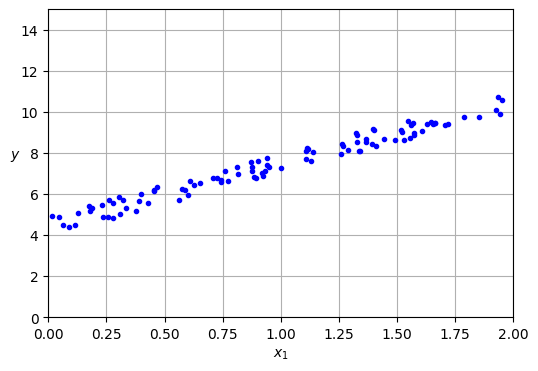

In [32]:
plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.show()

In [33]:
print("X-Data shape: ", X_b.shape, "Transpose: ", X_b.T.shape)
print("y-Data shape: ", y.shape)

X-Data shape:  (100, 2) Transpose:  (2, 100)
y-Data shape:  (100, 1)


In [34]:
from sklearn.preprocessing import add_dummy_feature  # Se usa para aumentar el dataset agreando una dummy feature (generalmente vale 1)

X_b = add_dummy_feature(X)  # Using a dummy variable to simulate theta_0 = 1
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y  # Maximum Likehood estimation solution for the parameters 
print("Analytic Theta: \n", *theta_best)


Analytic Theta: 
 [4.57201738] [2.92706591]


In [35]:
# Usamos y = X * theta_best 
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new)  # add x0 = 1 to each instance
y_predict = X_new_b @ theta_best
print("X_new", *X_new_b)
print("y_pred", *y_predict)

X_new [1. 0.] [1. 2.]
y_pred [4.57201738] [10.42614921]


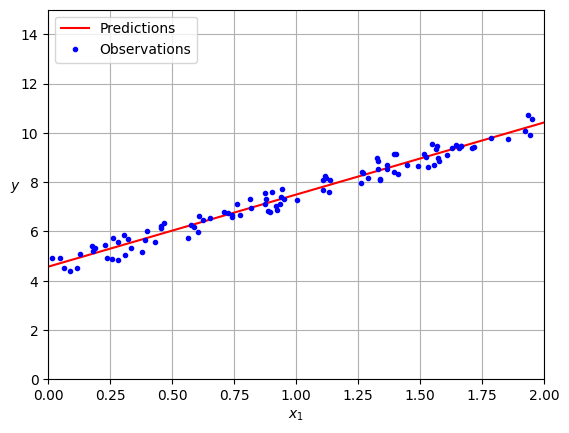

In [36]:
plt.plot(X_new, y_predict, "r-", label="Predictions")
plt.plot(X, y, "b.", label="Observations")

plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.legend(loc="upper left")

In [37]:
# Using the linear regression model from sklearn
from sklearn.linear_model import LinearRegression

LR = LinearRegression()
LR.fit(X, y)
print("Intercept: ", LR.intercept_, "Slope: ", LR.coef_)  # Coincides with the line simulated

Intercept:  [4.57201738] Slope:  [[2.92706591]]


## Implementation

In [92]:
def MSE_gradient(X: np.ndarray, y: np.ndarray, Theta: np.ndarray): 
    """Gradient of the empirical risk over the param for the MSE"""
    m = len(X)
    # print(X.T.shape, X.shape, Theta.shape, y.shape)
    return 2 / m * X.T @ (X @ Theta - y)

In [ ]:
def plot_error(error):
    """Plot the errors over the epochs."""
    mse = [np.mean(e**2) for e in error]
    plt.figure(figsize=(8, 4))
    plt.plot(mse, label="MSE")
    plt.title('Mean Squared Error over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_theta_hist(theta_hist, X, y):
    """Plot the path of gradient descent in parameter space (theta_0 vs theta_1)."""
    theta_hist = np.array(theta_hist)  # shape: (n_epochs, 2)

    plt.figure(figsize=(6, 6))
    plt.plot(theta_hist[:, 0], theta_hist[:, 1], 'o-', markersize=3, linewidth=1, label='Path')
    plt.title('Gradient Descent Path in Parameter Space')
    plt.xlabel(r'$\theta_0$')
    plt.ylabel(r'$\theta_1$')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [93]:
class GD: 
    """Base class for gradient descent algorithms."""
    def __init__(self, 
                 X: np.ndarray, 
                 y: np.ndarray, 
                 learning_rate: float = 0.1, 
                 n_epoch: int = 1000):
        self.X = X
        self.y = y
        self.eta = learning_rate
        self.n_epoch = n_epoch

    def optimice(self, initial_weights: np.ndarray = None):
        """Method that will be implemented in the subclasses."""

        raise NotImplementedError("This method must be implemented by a subclass.") 

### Batch Gradient Descent (BGD)

BGD es una variante de GD en la que se calcula el gradiente utilizando el conjunto de entrenamiento antes de realizar una sola actualización de los parámetros. 

Ventajas: 
- Proporciona una dirección más precisa hacia el mínimo global. 
- Buen rendimiento cuando los datos *caben* en memoría. 

Desventajas: 
- Lento con datasets grandes. 
- Requiere gran cantidad de memoria. 

In [183]:
class BGD(GD): 
    def __init__(self, X, y, learning_rate = 0.1, n_epoch = 1000):
        super().__init__(X, y, learning_rate, n_epoch)

    def optimice(self, initial_weights = None):
        if initial_weights is None: 
            theta = np.random.rand(self.X.shape[1], 1)  # Randomly initialized model params
        else:
            theta = initial_weights
        
        m = len(self.X)
        thetas = []
        error = []
        
        start = time.time()
        for epoch in range(self.n_epoch): 
            gradients = MSE_gradient(self.X, self.y, theta)
            theta = theta - self.eta * gradients
            thetas.append(theta.flatten())
            error.append(np.abs(self.X @ theta - self.y))
        end = time.time() - start
        return theta, thetas, error, end

In [184]:
bgd = BGD(X_b, y, learning_rate=0.1, n_epoch=1000)
theta_bgd, theta_hist_bgd, error_bgd, ttime_bgd = bgd.optimice()

BGD Theta:  [4.57201738] [2.92706591]
BGD time:  0.022142648696899414


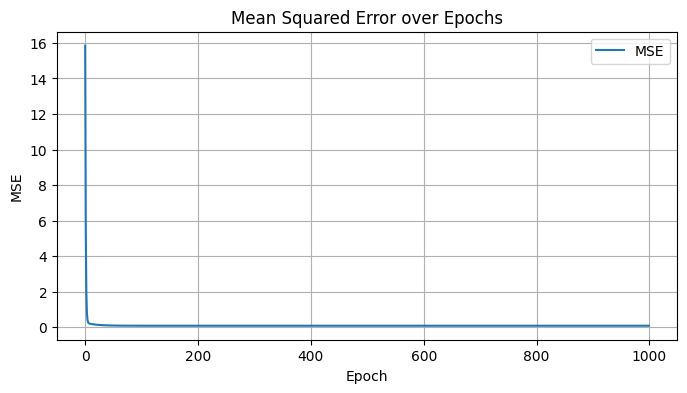

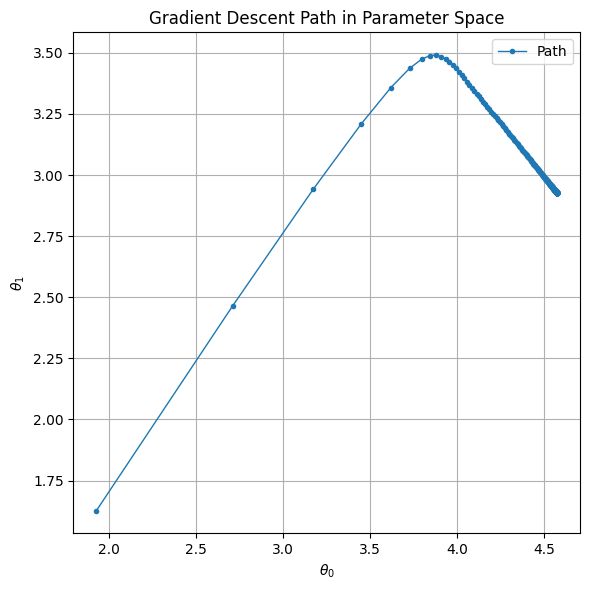

In [185]:
print("BGD Theta: ", *theta_bgd)
print("BGD time: ", ttime_bgd)
plot_error(error_bgd)
plot_theta_hist(theta_hist_bgd)

### SGD

In [ ]:
class SGD(GD): 
    def __init__(self, X, y, learning_rate = 0.1, n_epoch = 1000, seed: int = 42):
        super().__init__(X, y, learning_rate, n_epoch)
        self.rng = np.random.default_rng(seed)
    
    @staticmethod
    def learning_schedule(t):
        """Determines the learning rate at each iteration. """
        t0, t1 = 5, 50  # Learning schedule hyperparameters
        return t0 / (t + t1) 


    def optimice(self, initial_weights = None):
        if initial_weights is None: 
            theta = self.rng.random((2, 1))  # Randomly initialized model params
        else:
            theta = initial_weights
        
        m = len(self.X)
        thetas = []
        error = []
        
        start = time.time()
        for epoch in range(self.n_epoch):  
            for i in range(m):
                random_index = rng.integers(m)
                xi = self.X[random_index:random_index + 1]
                yi = self.y[random_index: random_index + 1]
                gradients = 2 * xi.T @ (xi @ theta - yi)  # Using non-compacted MSE
                eta = self.learning_schedule(epoch * m + i)
                theta = theta - eta * gradients
                thetas.append(theta.flatten())
                error.append(np.abs(self.X @ theta - self.y))
        end = start - time.time()
        return theta, thetas, error, end

In [181]:
sgd = SGD(X_b, y, learning_rate=0.1, n_epoch=50)
theta_sgd, theta_hist_sgd, error_sgd, ttime_sgd = sgd.optimice()

SGD Theta:  [4.5839698] [2.91257094]
BGD time:  <module 'time' (built-in)>


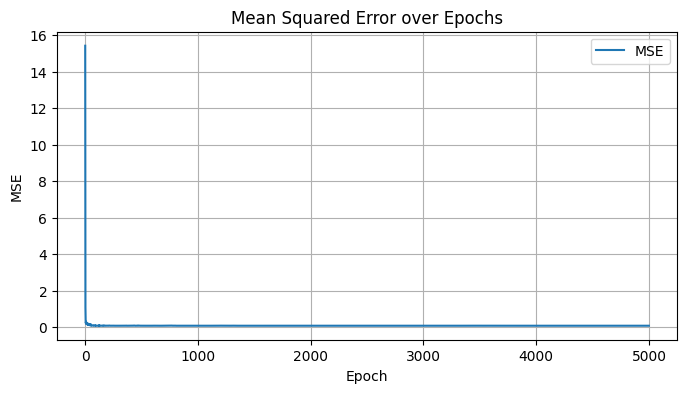

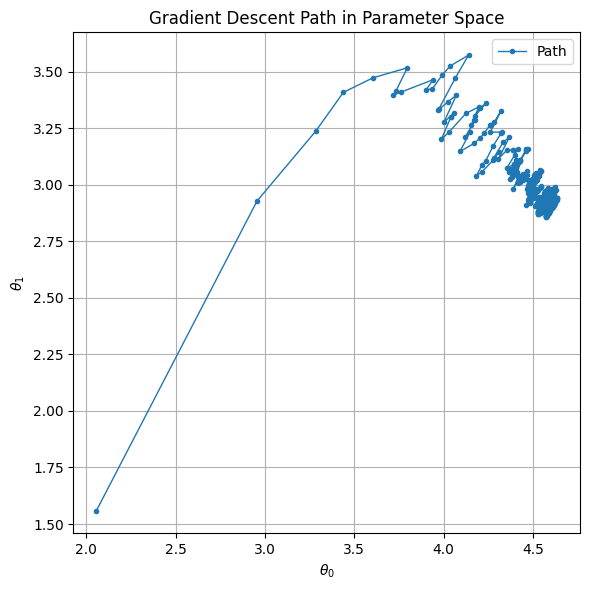

In [182]:
print("SGD Theta: ", *theta_sgd)
print("BGD time: ", ttime_sgd)
plot_error(error_sgd)
plot_theta_hist(theta_hist_sgd)

### Mini-batch GD

MGD es una combinación entre BGD y SGD. Se actulizan los parámetros utilizando un pequelo grupo de muestras (batch) en cada iteración. 
Es la técnica más usada en la práctica, ya que cofrece un equilibrio entre la eficiencia computacional y la estabilidad. 
Ventajas: 
- Menos varianza que SGD. 
- Más eficiente que BGD. 

Desventajas: 
- La elección del tamaño del mini-batch puede afectar el rendimiento. 

El tamaño típico de un mini-batch suele estar entre 32 y 512 muestras. 

In [186]:
from math import ceil

In [187]:
class MGD(GD): 
    def __init__(self, X, y, learning_rate = 0.1, n_epoch = 1000, minibatch_size: int = 20, seed: int = 42):
        super().__init__(X, y, learning_rate, n_epoch)
        self.bsize = minibatch_size
        self.rng = np.random.default_rng(seed)
    
    @staticmethod
    def learning_schedule(t):
        """Determines the learning rate at each iteration. """
        t0, t1 = 5, 50  # Learning schedule hyperparameters
        return t0 / (t + t1)
    
    def optimice(self, initial_weights = None):
        if initial_weights is None: 
            theta = self.rng.random((2, 1))  # Randomly initialized model params
        else:
            theta = initial_weights
        
        m = len(self.X)
        n_batches_per_epoch = ceil(m / self.bsize)
        thetas = []
        error = []
        start = time.time()
        for epoch in range(self.n_epoch): 
            shuffled_indices = rng.permutation(m)
            X_shuffled = self.X[shuffled_indices]
            y_shuffled = self.y[shuffled_indices]

            for iteration in range(0, n_batches_per_epoch): 
                idx =  iteration * self.bsize
                xi = X_shuffled[idx : idx + self.bsize]
                yi = y_shuffled[idx : idx + self.bsize]
                gradients = 2 / self.bsize * xi.T @ (xi @ theta - yi)
                eta = self.learning_schedule(iteration)
                theta = theta - eta * gradients
                thetas.append(theta.flatten())
                error.append(np.abs(self.X @ theta - self.y))
        end = start - time.time()
        return theta, thetas, error, end

In [ ]:
mgd = MGD(X_b, y, learning_rate=0.1, n_epoch=50, minibatch_size=20)
theta_sgd, theta_hist_sgd, error_sgd, ttime_sgd = sgd.optimice()

SGD Theta:  [4.5839698] [2.91257094]
BGD time:  <module 'time' (built-in)>


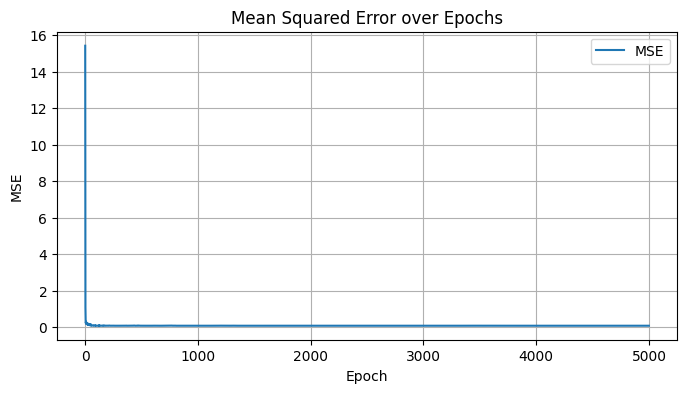

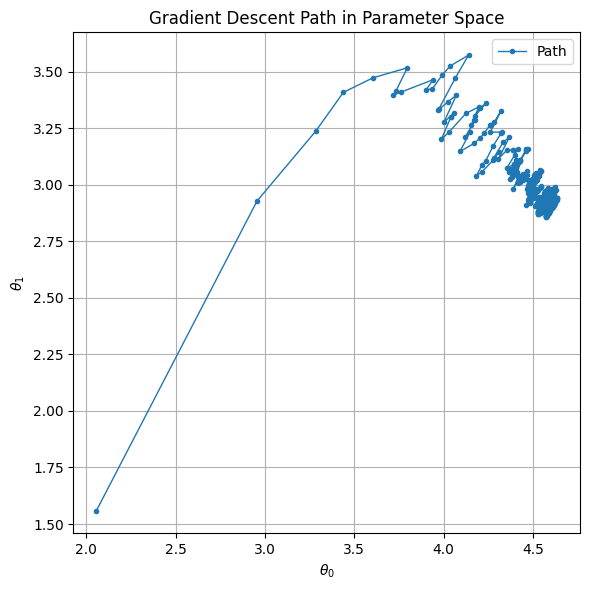

In [ ]:
print("SGD Theta: ", *theta_sgd)
print("BGD time: ", ttime_sgd)
plot_error(error_sgd)
plot_theta_hist(theta_hist_sgd)

## Results

## Conclusion